## 3 : Exploratory Visualization
### Character width and height

In [26]:
# These are all the modules I'll be using later. 
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import pandas as pd
import urllib
import cPickle as pickle
from PIL import Image
import scipy.io as sio
import scipy.io
import h5py
import random
import tensorflow as tf
from sklearn.cross_validation import train_test_split as ttsplit
import math as math
import pylab as P
%matplotlib inline

In [27]:
def open_pickle(folder, force=False):
  set_filename = folder + '.pickle'
  if os.path.exists(set_filename) and not force:
    with open(set_filename, 'rb') as f:
      dataset = pickle.load(f)
      return dataset
  else:
    
    print ('Unable to open data to', set_filename, '.')
    
train_data = open_pickle('train')
test_data = open_pickle('test')
extra_data = open_pickle('extra')

train_folders = 'train'
test_folders = 'test'
extra_folders = 'extra'

---

In [57]:
def generate_dataset(data, folder):

    dataset = np.ndarray([len(data),32,32,1], dtype=np.float32)
    labels = np.ones([len(data),6], dtype=int) * 10
    for i in np.arange(len(data)):
        name = data[i]['filename']
        fillename = os.path.join(folder, name)
        img = Image.open(fillename)
        boxes = data[i]['boxes']
        num_digit = len(boxes)
        labels[i,0] = num_digit
        top = np.ndarray([num_digit], dtype=np.float32)
        left = np.ndarray([num_digit], dtype=np.float32)
        height = np.ndarray([num_digit], dtype=np.float32)
        width = np.ndarray([num_digit], dtype=np.float32)
        for j in np.arange(num_digit):
            if j < 5: 
                labels[i,j+1] = boxes[j]['label']
                if boxes[j]['label'] == 10:
                    labels[i,j+1] = 0
            else:
                print('#',i,'image has more than 5 digits.')
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left
        
        im_top = np.floor(im_top - 0.1 * im_height)
        im_left = np.floor(im_left - 0.1 * im_width)
        im_bottom = np.amin([np.ceil(im_top + 1.2 * im_height), img.size[1]])
        im_right = np.amin([np.ceil(im_left + 1.2 * im_width), img.size[0]])

        img = img.crop((im_left, im_top, im_right, im_bottom)).resize([32,32], Image.ANTIALIAS)
        img = np.dot(np.array(img, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        mean = np.mean(img, dtype='float32')
        std = np.std(img, dtype='float32', ddof=1)
        if std < 1e-4: std = 1.
        img = (img - mean) / std
        dataset[i,:,:,:] = img[:,:,:]
        
    return dataset, labels

In [58]:
train_dataset, train_labels = generate_dataset(train_data, train_folders)
test_dataset, test_labels = generate_dataset(test_data, test_folders)
extra_dataset, extra_labels = generate_dataset(extra_data, extra_folders)

# 29929 image has more than 5 digits.


In [59]:
print(train_dataset.shape, train_labels.shape)
print(test_dataset.shape, test_labels.shape)
print(extra_dataset.shape, extra_labels.shape)

(33402, 32, 32, 1) (33402, 6)
(13068, 32, 32, 1) (13068, 6)
(202353, 32, 32, 1) (202353, 6)


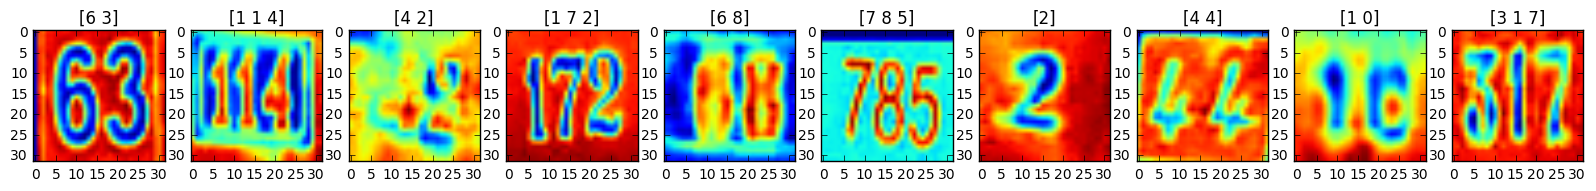

In [75]:
display_size  = 10
fig = P.figure(figsize=(20, 20))
rand_indices = np.random.randint(0, train_dataset.shape[0], display_size)

for x in range(len(rand_indices)):
    idx = rand_indices[x]
    a = fig.add_subplot(1, dp_size, x+1)
    
    P.imshow(train_dataset[idx,:,:,0])
    a.set_title(str(train_labels[idx, 1:1+train_labels[idx, 0]]))

In [61]:
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)
print(train_dataset.shape, train_labels.shape)

(33401, 32, 32, 1) (33401, 6)


Let's divide it into train data and validation data!

In [62]:
train_data1, valid_data1, train_labels1, valid_labels1 = ttsplit(train_dataset, train_labels, test_size=0.15, random_state=7)    
train_data2, valid_data2, train_labels2, valid_labels2 = ttsplit(extra_dataset, extra_labels, test_size=0.001, random_state=7)

In [63]:
train_dataset = np.concatenate((train_data1, train_data2), axis=0)
train_labels = np.concatenate((train_labels1, train_labels2), axis=0)
valid_dataset = np.concatenate((valid_data1, valid_data2), axis =0)
valid_labels = np.concatenate((valid_labels1, valid_labels2), axis = 0)

In [64]:
print (train_dataset.shape, train_labels.shape)
print (valid_dataset.shape, valid_labels.shape)
print (test_dataset.shape, test_labels.shape)

(230540, 32, 32, 1) (230540, 6)
(5214, 32, 32, 1) (5214, 6)
(13068, 32, 32, 1) (13068, 6)


Next, I'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [65]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

In [66]:
train_dataset, train_labels = randomize(train_dataset, train_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---

In [67]:
pickle_file = 'SVHN.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [68]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1031118824
